# AUTOARIMA FORECASTING

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Load Train and Test Daily Delhi Climate Data

In [15]:

train = pd.read_csv('DailyDelhiClimateTrain.csv', parse_dates=['date'])
test = pd.read_csv('DailyDelhiClimateTest.csv', parse_dates=['date'])


## Do Some Feature Engineering

In [16]:
#Rename columns and keep only date and humidity
train = train[['date', 'humidity']].rename(columns={'date': 'ds', 'humidity': 'y'})
test = test[['date', 'humidity']].rename(columns={'date': 'ds', 'humidity': 'y'})

# Add unique_id column required by statsforecast
train['unique_id'] = 'humidity'
test['unique_id'] = 'humidity'

## Train Model and Forecast for the Test Set

In [17]:

# Train AutoARIMA model
sf = StatsForecast(
    models=[AutoARIMA()],
    freq='D',
    n_jobs=-1
)
fitted=sf.fit(train)

# Forecast for the length of the test set
h = len(test)
forecast = fitted.predict(h=h,level=[95])

# Align forecast dates with test dates
forecast['ds'] = test['ds'].values

## Plot with Precision Interval

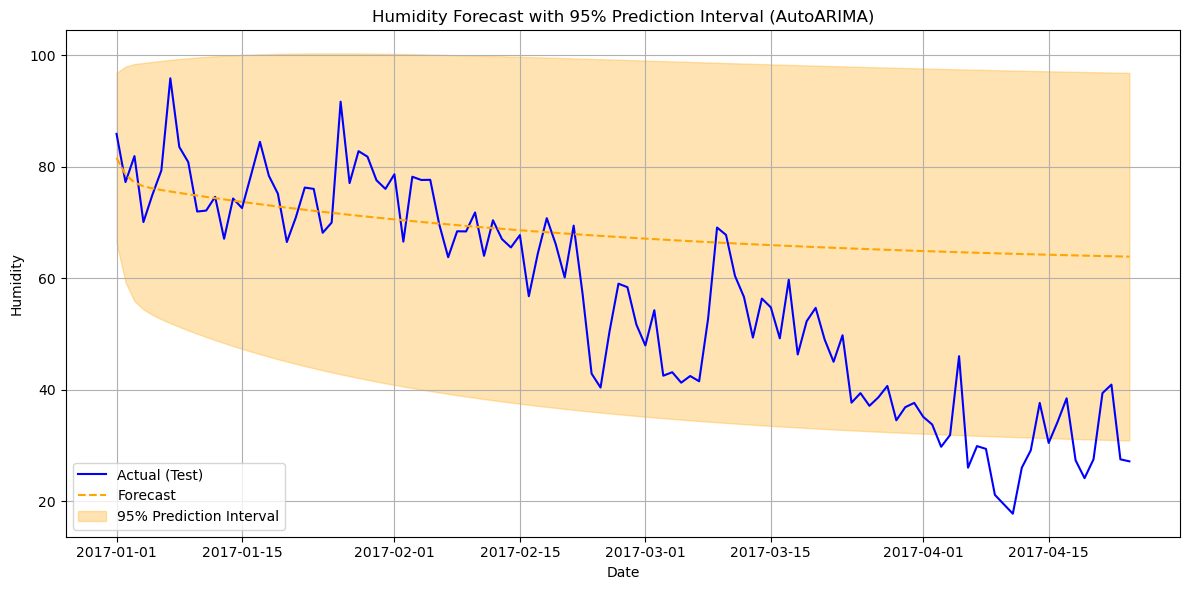

In [18]:

plt.figure(figsize=(12, 6))

plt.plot(test['ds'], test['y'], label='Actual (Test)', color='blue')
plt.plot(forecast['ds'], forecast['AutoARIMA'], label='Forecast', color='orange', linestyle='--')

# Plot 95% prediction interval
plt.fill_between(
    forecast['ds'],
    forecast['AutoARIMA-lo-95'],
    forecast['AutoARIMA-hi-95'],
    color='orange',
    alpha=0.3,
    label='95% Prediction Interval'
)

plt.title('Humidity Forecast with 95% Prediction Interval (AutoARIMA)')
plt.xlabel('Date')
plt.ylabel('Humidity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("AutoARIMAPLOT.png")
plt.show()

## Error Computation

In [19]:

mse = mean_squared_error(test['y'], forecast['AutoARIMA'])


rmse = np.sqrt(mse)


mae = mean_absolute_error(test['y'], forecast['AutoARIMA'])

print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")

Test MSE:  398.1900
Test RMSE: 19.9547
Test MAE:  15.3691


## Compute Coverage of 95% prediction interval

In [20]:
# Step 5: Compute coverage of 95% prediction interval
actual = test['y'].values
lower = forecast['AutoARIMA-lo-95'].values
upper = forecast['AutoARIMA-hi-95'].values

# Check how many actual values fall inside the interval
inside_interval = ((actual >= lower) & (actual <= upper)).sum()
coverage = inside_interval / len(actual) * 100

print(f"95% Prediction Interval Coverage: {coverage:.2f}%")

95% Prediction Interval Coverage: 85.96%


## Interpretability

In [21]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Fit standalone AutoARIMA to extract parameters
aa = AutoARIMA(season_length=1).fit(train['y'].to_numpy())

order = getattr(aa, 'order', None) or getattr(aa, 'model_', {}).get('order')
seasonal_order = getattr(aa, 'seasonal_order', None) or getattr(aa, 'model_', {}).get('seasonal_order')

print("\nSelected ARIMA order (p,d,q):", order)
if order is not None:
    print("Differencing order d:", order[1])
if seasonal_order:
    print("Selected seasonal order (P,D,Q,s):", seasonal_order)

# Stationarity test
def kpss_result(x, regression='c'):
    stat, pval, *_ = kpss(x, regression=regression, nlags='auto')
    return pval

print("\nKPSS p-value (orig, level):", kpss_result(orig_y, regression='c'))
print("KPSS p-value (orig, trend):", kpss_result(orig_y, regression='ct'))
print("KPSS p-value (diff, level):", kpss_result(diff_y, regression='c'),
      "(p>0.05 suggests stationarity)")



Selected ARIMA order (p,d,q): None

KPSS p-value (orig, level): 0.1
KPSS p-value (orig, trend): 0.1
KPSS p-value (diff, level): 0.1 (p>0.05 suggests stationarity)


## Data and Interpretability Plots

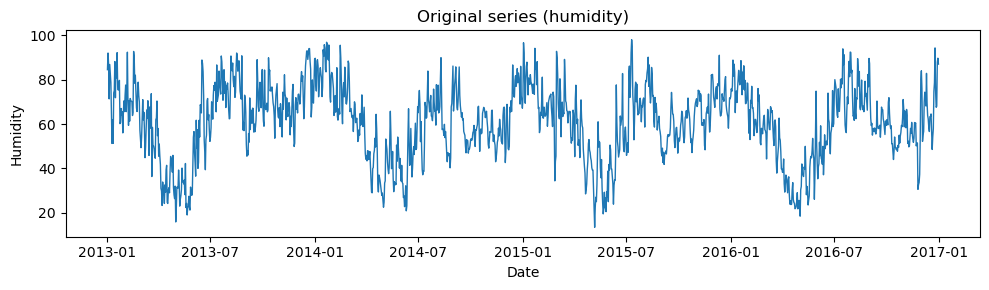

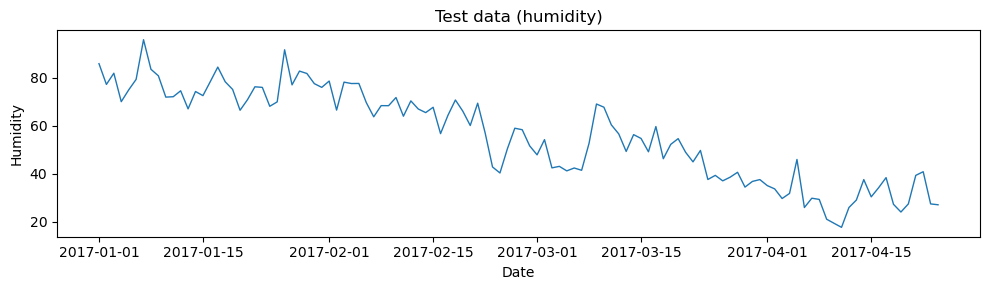

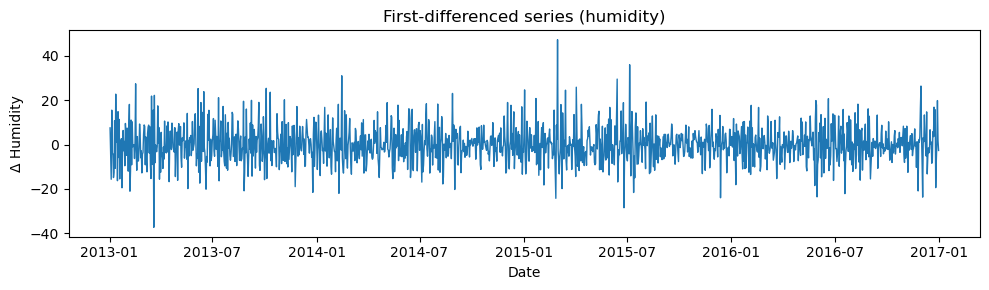

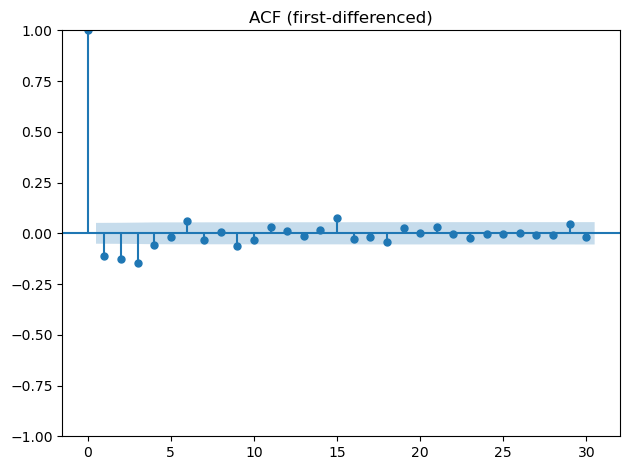

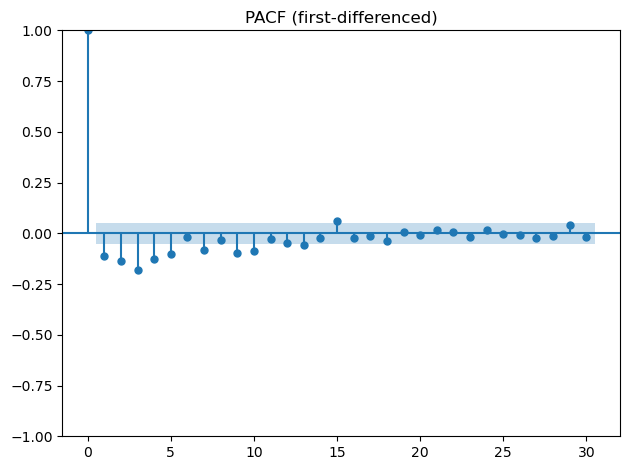

In [27]:

# Plots
plt.figure(figsize=(10,3))
plt.plot(train['ds'], orig_y, linewidth=1)
plt.title("Original series (humidity)")
plt.xlabel("Date")
plt.ylabel("Humidity")
plt.tight_layout()
plt.savefig("OriginalDataPLOT.png")
plt.show()

plt.figure(figsize=(10,3))
plt.plot(test['ds'], test['y'], linewidth=1)
plt.title("Test data (humidity)")
plt.xlabel("Date")
plt.ylabel("Humidity")
plt.tight_layout()
plt.savefig("TestDataPLOT.png")
plt.show()

plt.figure(figsize=(10,3))
plt.plot(train['ds'].iloc[1:], diff_y, linewidth=1)
plt.title("First-differenced series (humidity)")
plt.xlabel("Date")
plt.ylabel("Δ Humidity")
plt.tight_layout()
plt.savefig("FirstDifferencedPLOT.png")
plt.show()

plot_acf(diff_y, lags=30)
plt.title("ACF (first-differenced)")
plt.tight_layout()
plt.savefig("ACFPLOT.png")
plt.show()

plot_pacf(diff_y, lags=30, method='ywm')
plt.title("PACF (first-differenced)")
plt.tight_layout()
plt.savefig("PACFPLOT.png")
plt.show()